In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from kneed import KneeLocator
from sklearn.decomposition import PCA

In [2]:
def load_data(filepath):
    df=pd.read_csv(filepath)
    x=torch.tensor(df.iloc[:,:-1].values,dtype=torch.float32,device="cuda")  
    y=torch.tensor(df.iloc[:,-1].values,dtype=torch.int32,device="cuda")  
    return x,y

In [3]:
def initialize_centroids(x,k):
    indices=torch.randperm(x.shape[0])[:k]
    return x[indices].clone()

In [4]:
def assign_clusters(x,centroids):
    distances=torch.cdist(x,centroids)
    return torch.argmin(distances,dim=1)

In [5]:
def update_centroids(x,clusters,k):
    new_centroids=torch.stack([x[clusters==i].mean(dim=0) for i in range(k)])
    return new_centroids

In [6]:
def kmeans(x,k,max_iters=100,tol=1e-4):
    centroids=initialize_centroids(x,k)
    for _ in range(max_iters):
        clusters=assign_clusters(x,centroids)
        new_centroids=update_centroids(x,clusters,k)
        if torch.norm(new_centroids-centroids)<tol:
            break
        centroids=new_centroids
    return centroids,clusters

In [7]:
def elbow_method(x,max_k=10):
    distortions=[]
    for k in range(1,max_k+1):
        centroids,clusters=kmeans(x,k)
        distortion=torch.mean(torch.min(torch.cdist(x,centroids),dim=1)[0]**2).item()
        distortions.append(distortion)

    kneedle=KneeLocator(range(1,max_k+1),distortions,curve='convex',direction='decreasing')
    optimal_k=kneedle.elbow

    plt.figure(figsize=(8,5))
    plt.plot(range(1,max_k+1), distortions,'bo-',markersize=8,linewidth=2,label='Distortion')
    plt.vlines(optimal_k,plt.ylim()[0],plt.ylim()[1],colors='r',linestyles='dashed',label=f'Optimal k={optimal_k}')
    plt.xlabel('Number of clusters(k)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal k')
    plt.legend()
    plt.show()
    return optimal_k

In [ ]:
def visualize_clusters(X, clusters, centroids, y):
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X.cpu().numpy())
    clusters_np = clusters.cpu().numpy()
    y_np = y.cpu().numpy()  

    unique_clusters = np.unique(clusters_np)
    unique_classes = np.unique(y_np)

    cluster_class_percentages = {}
    for cluster in unique_clusters:
        cluster_mask=(clusters_np == cluster)
        cluster_labels=y_np[cluster_mask]
        total_points_in_cluster=len(cluster_labels)
        class_percentages={}
        for class_label in unique_classes:
            class_count=np.sum(cluster_labels == class_label)
            class_percentages[class_label]=(class_count/total_points_in_cluster)*100
        cluster_class_percentages[cluster]=class_percentages

    plt.figure(figsize=(10, 8))
    scatter=plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters_np, cmap='viridis', alpha=0.6)
    centroids_reduced=pca.transform(centroids.cpu().numpy())
    plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], c='red', marker='X', s=200, label='Centroids')

    for cluster in unique_clusters:
        cluster_points=X_reduced[clusters_np==cluster]
        cluster_center=np.mean(cluster_points, axis=0)
        
        if cluster in cluster_class_percentages:
            class_percentages=cluster_class_percentages[cluster]
            percentage_text="\n".join([f"Class {cls}: {pct:.2f}%" for cls, pct in class_percentages.items()])
            plt.text(cluster_center[0], cluster_center[1], percentage_text, fontsize=10, fontweight='bold', color='black', ha='center')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'K-Means Clustering with Optimal k')
    plt.legend()
    plt.show()


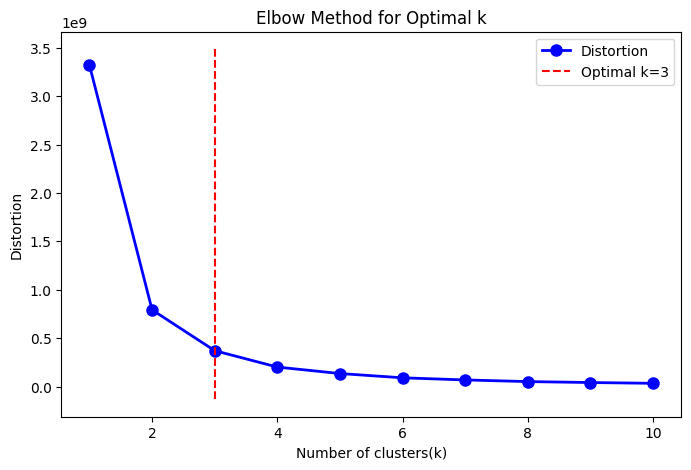

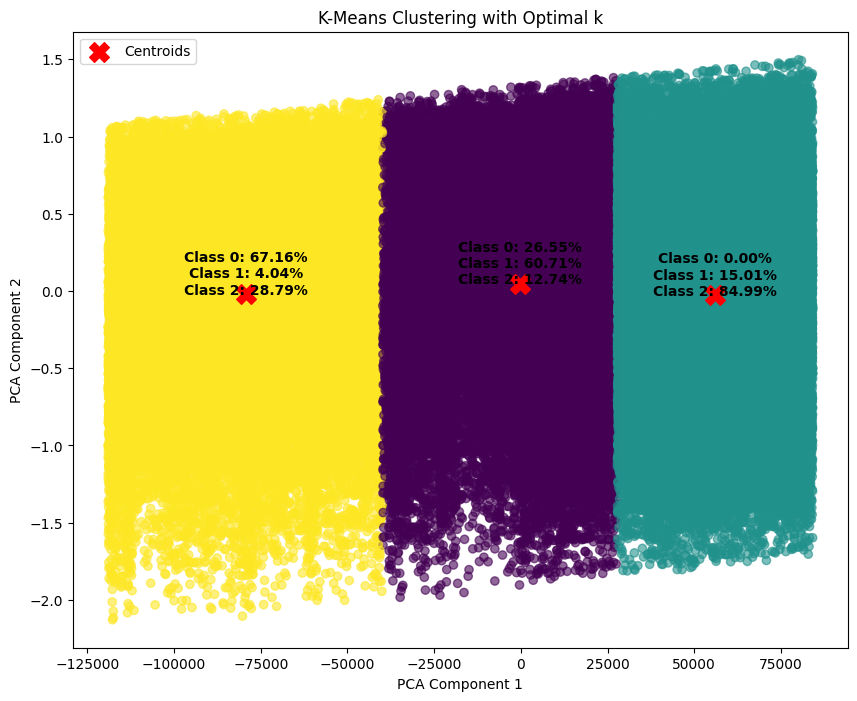

In [ ]:
def main(filepath):
    x,y=load_data(filepath)
    optimal_k=elbow_method(x)
    centroids,clusters=kmeans(x,optimal_k)
    visualize_clusters(x, clusters, centroids, y)

if __name__=="__main__":
    filepath="cleaned.csv"  
    main(filepath)
